In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np

In [40]:
permitted_cols = ['seconds_elapsed', 'accelerometer_z', 'accelerometer_y',
       'accelerometer_x', 'gravity_z', 'gravity_y', 'gravity_x', 'gyroscope_z',
       'gyroscope_y', 'gyroscope_x', 'orientation_qz', 'orientation_qy',
       'orientation_qx', 'orientation_qw', 'orientation_roll',
       'orientation_pitch', 'orientation_yaw', 'magnetometer_z',
       'magnetometer_y', 'magnetometer_x', 'compass_magneticBearing',
       'barometer_relativeAltitude', 'barometer_pressure',
       'location_bearing', 'location_altitude', 'location_longitude', 
       'location_latitude', 'microphone_dBFS', 'light_lux', 'batteryTemp_temperature']

col_synonyms = ['seconds_elapsed', 'Acc.z', 'Acc.y',
       'Acc.x', 'Grav.z', 'Grav.y', 'Grav.x', 'Gyr.z',
       'Gyr.y', 'Gyr.x', 'Ori.qz', 'Ori.qy',
       'Ori.qx', 'Ori.qw', 'Ori.roll',
       'Ori.pitch', 'Ori.yaw', 'Mag.z',
       'Mag.y', 'Mag.x', 'Comp.bear',
       'Bar.alt', 'Bar.press', # Bar = Barometer. Alt = Altitude
       'Loc.bear', 'Loc.alt', 'Loc.long', 
       'Loc.lat', 'Sound', 'Light', 'Temp']

pixel_garden = pd.read_csv("data/garden/GardenPixel-2025-03-23_17-03-12-8132b4b89fb54aa7a9762a4a82d6863d.csv",
                          usecols=permitted_cols).dropna()

pixel_garden = pixel_garden.rename(columns=dict(zip(permitted_cols, col_synonyms)))

In [41]:
display(pixel_garden.columns)
display(pixel_garden.shape)

Index(['seconds_elapsed', 'Acc.z', 'Acc.y', 'Acc.x', 'Grav.z', 'Grav.y',
       'Grav.x', 'Gyr.z', 'Gyr.y', 'Gyr.x', 'Ori.qz', 'Ori.qy', 'Ori.qx',
       'Ori.qw', 'Ori.roll', 'Ori.pitch', 'Ori.yaw', 'Mag.z', 'Mag.y', 'Mag.x',
       'Comp.bear', 'Bar.alt', 'Bar.press', 'Loc.bear', 'Loc.alt', 'Loc.long',
       'Loc.lat', 'Sound', 'Light', 'Temp'],
      dtype='object')

(90171, 30)

<Axes: xlabel='Temp', ylabel='Count'>

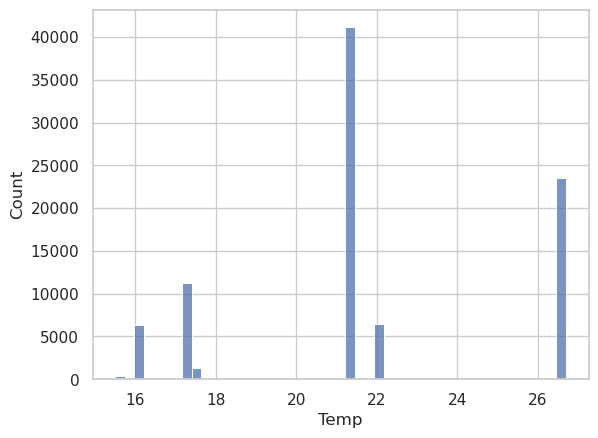

In [43]:
# Example plot
sns.histplot(pixel_garden["Temp"])

<Axes: >

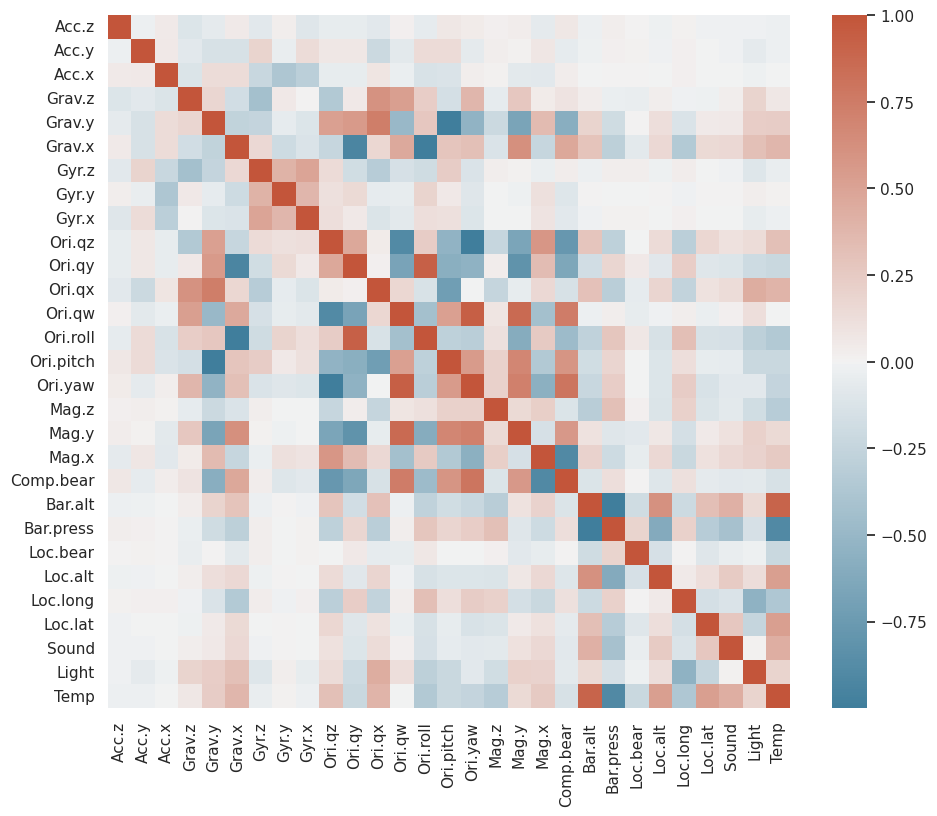

In [44]:
sns.set_theme(style="whitegrid")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(pixel_garden.drop("seconds_elapsed", axis=1).corr(), cmap=cmap)

In [45]:
def shannon_entropy(series, base=2):    
    # Calculate the frequency of each unique value.
    counts = series.value_counts()
    
    # Convert counts to probabilities.
    probabilities = counts / counts.sum()
    
    # Calculate the entropy using the formula:
    # H(X) = - sum(p_i * log(p_i))
    # The logarithm base can be adjusted; here, we use natural log and convert by dividing by log(base).
    return -np.sum(probabilities * np.log(probabilities)) / np.log(base)


def expected_guessing_entropy(series):    
    # Compute the frequency of each unique value.
    # .value_counts() returns counts sorted in descending order by default.
    counts = series.value_counts()
    
    # Convert counts to probabilities.
    probabilities = counts / counts.sum()
    
    # Ensure probabilities are sorted in descending order.
    probabilities = probabilities.sort_values(ascending=False)
    
    # Create an array of ranks starting from 1 to the number of unique outcomes.
    ranks = np.arange(1, len(probabilities) + 1)
    
    # Return expected guessing entropy as the weighted sum of ranks.
    return np.sum(ranks * probabilities.values)


def marginal_guesswork(series, alpha=0.9):
    # Calculate frequency counts (sorted descending by default).
    counts = series.value_counts()
    
    # Convert counts to probabilities.
    probabilities = counts / counts.sum()
    
    # Compute cumulative probabilities.
    cum_probs = probabilities.cumsum().values
    
    # When alpha is 1 (or nearly 1), return the total number of unique outcomes.
    if np.isclose(alpha, 1.0):
        return len(cum_probs)
    
    # Find the smallest index k where the cumulative probability >= alpha.
    # np.argmax returns the first occurrence where the condition is True.
    k = np.argmax(cum_probs >= alpha) + 1  # +1 because guesses are 1-indexed.
    return k


def massey_bound(series):
    return 0.25 * ((2**shannon_entropy(series))-1)

In [46]:
def display_entropies(series):
    display(f"H(X)    = {shannon_entropy(series)}")
    display(f"E[G(X)] ≥ {massey_bound(series)}")
    display(f"E[G(X)] = {expected_guessing_entropy(series)}")

In [48]:
display_entropies(pixel_garden["Acc.x"])

'H(X)    = 15.459623134391496'

'E[G(X)] ≥ 11265.245379539923'

'E[G(X)] = 21822.54136030431'

In [49]:
def simulate_average_guesses(series, n=1000):    
    # Compute frequency counts; value_counts() returns counts sorted in descending order.
    counts = series.value_counts()
    
    # The guess order is fixed:
    guess_order = counts.index.to_numpy()  # Unique outcomes in sorted order (most frequent first)
    
    # Compute the probabilities corresponding to the guess order.
    probabilities = counts.to_numpy() / counts.to_numpy().sum()
    
    # Instead of looping, sample indices (representing the rank) directly in a vectorized manner.
    # Since guess_order is in descending order, if an outcome is at index i, the number of guesses is i+1.
    sampled_indices = np.random.choice(len(guess_order), size=n, p=probabilities)
    # Compute the average number of guesses (adding 1 because ranks are 0-indexed).
    avg_guesses = np.mean(sampled_indices + 1)
    return sampled_indices, avg_guesses

def min_entropy(series):    
    # Calculate the frequency of each unique value.
    counts = series.value_counts()
    
    # Convert counts to probabilities.
    probabilities = counts / counts.sum()
    
    # Get the maximum probability
    max_prob = probabilities.max()
    # Compute and return the min-entropy using base 2 logarithm
    return -np.log2(max_prob)

In [53]:
marginal_guesswork(pixel_garden["Acc.z"])

13127

In [55]:
results = []

# Iterate over the columns of interest and compute the values.
for col in pixel_garden.columns[1:]:
    series = pixel_garden[col]
    entropy = shannon_entropy(series)
    massey = massey_bound(series)
    exp_guess = expected_guessing_entropy(series)
    min_entropy_val = min_entropy(series)
    
    results.append({
        'Sensor': col,
        'H(X)': entropy,
        'H_{\inf}(X)': min_entropy_val,
        'E[G(X)]': exp_guess
    })

# Create a DataFrame from the results and display it.
results_df = pd.DataFrame(results)
display(results_df.round(3))

<>:14: SyntaxWarning: invalid escape sequence '\i'
<>:14: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_16283/3232402330.py:14: SyntaxWarning: invalid escape sequence '\i'
  'H_{\inf}(X)': min_entropy_val,


,Sensor,H(X),H_{\inf}(X),E[G(X)]
0,Acc.z,13.680,11.103,5171.731
1,Acc.y,15.412,13.460,20850.237
2,Acc.x,15.460,13.460,21822.541
3,Grav.z,9.364,7.599,260.346
4,Grav.y,16.174,13.875,34313.299
5,Grav.x,16.298,14.138,38537.535
6,Gyr.z,4.480,3.358,13.674
7,Gyr.y,4.966,3.736,21.617
8,Gyr.x,4.750,3.558,19.947
9,Ori.qz,15.324,13.138,16822.535
